In [1]:
import os
import sys
from pathlib import Path

workding_dir = str(Path.cwd().parent)
os.chdir(workding_dir)
sys.path.append(workding_dir)
print("workding dir:", workding_dir)

workding dir: /Users/inflaton/code/engd/papers/orca-2/Evaluation-of-Orca-2-Models-for-Conversational-RAG


In [2]:
import pandas as pd
import matplotlib.pyplot as plt

perf_pd1 = pd.read_excel("./results/perf_data.xlsx")

## Results from Nvidia GeForce RTX 4090

In [3]:
perf_pd1 = perf_pd1.drop(13)  # gpt-3.5-turbo-instruct
perf_pd1

,model_name,repetition_penalty,faithfulness,answer_relevancy,overall_score,total_time_used,num_tokens_generated,token_per_second
0,orca-2-7b,1.05,0.830357,0.978324,0.898288,46.121,536,11.622
1,orca-2-7b,1.10,0.750000,0.974817,0.847757,20.195,652,32.286
2,orca-2-7b,1.15,1.000000,0.973278,0.986458,13.672,454,33.208
3,llama-2-7b,1.05,0.875000,0.715099,0.787010,19.468,679,34.878
4,llama-2-7b,1.10,0.879630,0.731304,0.798638,21.670,759,35.026
5,llama-2-7b,1.15,1.000000,0.711172,0.831210,22.604,803,35.524
6,orca-2-13b,1.05,1.000000,0.987592,0.993757,397.548,641,1.612
7,orca-2-13b,1.10,1.000000,0.960806,0.980011,272.891,478,1.752
8,orca-2-13b,1.15,0.950000,0.961115,0.955525,291.610,514,1.763
9,llama-2-13b,1.05,0.900000,0.962428,0.930168,369.084,677,1.834


In [4]:
idx = perf_pd1.groupby("model_name")["overall_score"].idxmax()
df = perf_pd1.loc[idx].sort_index(ascending=False)
df

,model_name,repetition_penalty,faithfulness,answer_relevancy,overall_score,total_time_used,num_tokens_generated,token_per_second
14,gpt-4,NaN,1.000000,0.701869,0.824822,42.257,670,15.855
12,gpt-3.5-turbo,NaN,0.958333,0.483574,0.642795,13.232,425,32.119
11,llama-2-13b,1.15,0.944444,0.964647,0.954439,435.429,777,1.784
6,orca-2-13b,1.05,1.000000,0.987592,0.993757,397.548,641,1.612
5,llama-2-7b,1.15,1.000000,0.711172,0.831210,22.604,803,35.524
2,orca-2-7b,1.15,1.000000,0.973278,0.986458,13.672,454,33.208


In [5]:
scores = df.loc[:, ["model_name", "faithfulness", "answer_relevancy", "overall_score"]]
scores

,model_name,faithfulness,answer_relevancy,overall_score
14,gpt-4,1.000000,0.701869,0.824822
12,gpt-3.5-turbo,0.958333,0.483574,0.642795
11,llama-2-13b,0.944444,0.964647,0.954439
6,orca-2-13b,1.000000,0.987592,0.993757
5,llama-2-7b,1.000000,0.711172,0.831210
2,orca-2-7b,1.000000,0.973278,0.986458


In [6]:
gpt_model_names = {
    "gpt-4": "GPT-4",
    "gpt-3.5-turbo": "GPT-3.5-Turbo",
}
scores["model_name"] = scores["model_name"].apply(
    lambda x: gpt_model_names[x] if x in gpt_model_names else x.capitalize()
)
scores.rename(columns=lambda x: x.replace("_", " ").title(), inplace=True)
scores

,Model Name,Faithfulness,Answer Relevancy,Overall Score
14,GPT-4,1.000000,0.701869,0.824822
12,GPT-3.5-Turbo,0.958333,0.483574,0.642795
11,Llama-2-13b,0.944444,0.964647,0.954439
6,Orca-2-13b,1.000000,0.987592,0.993757
5,Llama-2-7b,1.000000,0.711172,0.831210
2,Orca-2-7b,1.000000,0.973278,0.986458


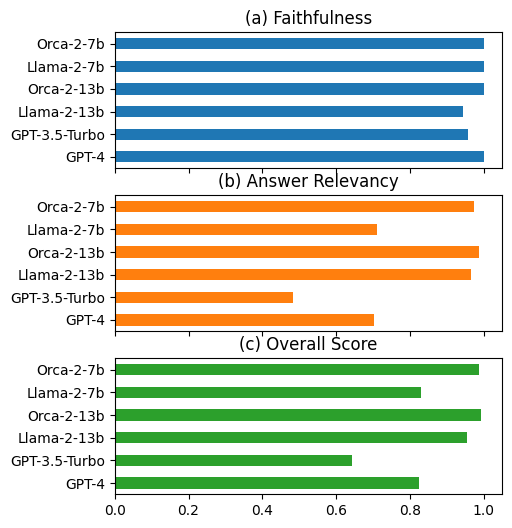

In [7]:
scores.plot.barh(
    x="Model Name",
    ylabel="",
    rot=0,
    figsize=(5, 6),
    subplots=True,
    title=["(a) Faithfulness", "(b) Answer Relevancy", "(c) Overall Score"],
    legend=False,
)
plt.savefig("./results/figures/perf_scores.eps", format="eps")

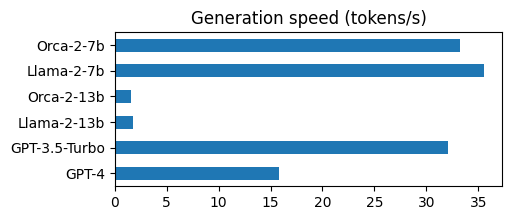

In [8]:
speed = df.loc[:, ["model_name", "token_per_second"]]
speed["model_name"] = speed["model_name"].apply(
    lambda x: gpt_model_names[x] if x in gpt_model_names else x.capitalize()
)

speed.plot.barh(
    x="model_name",
    ylabel="",
    rot=0,
    figsize=(5, 2),
    legend=False,
    title="Generation speed (tokens/s)",
)
plt.savefig("./results/figures/inference_speed.eps", format="eps")

In [9]:
selected = []
NUM_QUESTIONS = 4
for j in range(NUM_QUESTIONS):
    for i in idx.values:
        selected.append(i * NUM_QUESTIONS + j)

### Compare Answers from Different Models

In [10]:
raw_data = pd.read_excel("./results/raw_data.xlsx")
df = raw_data.loc[selected]

questions = df["user_question"].unique()
NUM_QUESTIONS = len(questions)

models = df["model_name"].unique()
NUM_MODELS = len(models)

NUM_QUESTIONS, NUM_MODELS

(4, 6)

In [11]:
df = df.drop(["repetition_penalty", "contexts"], axis=1)
df = df.fillna("")
df[df.columns] = df.apply(lambda x: x.str.strip())
df["standalone_question"] = df["standalone_question"].str.replace("\n", "**\n**")
df["standalone_question"] = df["standalone_question"].apply(
    lambda x: "{}{}{}".format("**", x, "**") if len(x) > 0 else x
)
df["standalone_question"] = df["standalone_question"].str.replace("****", "")
df["LLM Generated Content"] = (
    df["standalone_question"].str.cat(df["answer"], sep="\n").str.strip()
)
df["model_name"] = df["model_name"].apply(
    lambda x: gpt_model_names[x] if x in gpt_model_names else x.capitalize()
)
df = df.rename(columns={"model_name": "Model Name"})
df = df.drop(columns=["answer", "standalone_question", "user_question"])
df[df.columns] = df.apply(lambda x: x.str.strip())
df.reset_index(drop=True, inplace=True)
df

,Model Name,LLM Generated Content
0,GPT-3.5-Turbo,PCI DSS stands for Payment Card Industry Data ...
1,GPT-4,The PCI Data Security Standard (PCI DSS) is a ...
2,Llama-2-13b,PCI DSS stands for Payment Card Industry Data ...
3,Llama-2-7b,"According to the given quick reference guide, ..."
4,Orca-2-13b,PCI DSS is a global standard that provides a b...
5,Orca-2-7b,PCI DSS stands for Payment Card Industry Data ...
6,GPT-3.5-Turbo,**What are the differences between PCI DSS ver...
7,GPT-4,**Can you provide a summary of the changes tha...
8,Llama-2-13b,**What are the key changes between PCI DSS ver...
9,Llama-2-7b,**What are the key changes between PCI DSS ver...


In [12]:
conversations = []
for i in range(NUM_QUESTIONS):
    conversations.append(df[i * NUM_MODELS : i * NUM_MODELS + NUM_MODELS])

In [13]:
import vertopal
from dotenv import find_dotenv, load_dotenv

found_dotenv = find_dotenv(".env")

if len(found_dotenv) == 0:
    found_dotenv = find_dotenv(".env.example")
print(f"loading env vars from: {found_dotenv}")
load_dotenv(found_dotenv, override=False)


def convert_md_to_eps(filename):
    converter = vertopal.Converter(
        filename,
        app=os.environ.get("VERTOPAL_APP_ID"),
        token=os.environ.get("VERTOPAL_TOKEN"),
    )
    converter.convert("eps")
    converter.wait()
    if converter.is_converted():
        converter.download()
    else:
        print(f"failed to convert {filename}")

loading env vars from: /Users/inflaton/code/engd/papers/orca-2/Evaluation-of-Orca-2-Models-for-Conversational-RAG/.env


In [14]:
import hashlib


def save_conversation(index):
    filename = f"./results/markdowns/question_{index + 1}.md"
    print(f"filename: {filename}")
    with open(filename, "w") as f:
        f.write(f"### User Question ({index + 1}): {questions[index]}\n")
        f.write(conversations[index].to_markdown(index=False))

    with open(filename, "rb") as file_obj:
        file_contents = file_obj.read()

        md5_hash = hashlib.md5(file_contents).hexdigest()

        # 👇️ cfd2db7dd4ffe42ce26e0b57e7e8b342
        print(md5_hash)

    return filename
    # convert_md_to_eps(filename)

In [15]:
filenames = []
for i in range(len(questions)):
    filename = save_conversation(i)
    filenames.append(filename)

filename: ./results/markdowns/question_1.md
5ada4e765d2b001fd037e1ef9ddbb685
filename: ./results/markdowns/question_2.md
27d1d4fc4ef8c8d94552b85839a106cc
filename: ./results/markdowns/question_3.md
3cf9447131e05abb4d5d3576bc5bc61b
filename: ./results/markdowns/question_4.md
315d9b8017e4ec753dd7dbc492af2b88


In [16]:
# convert_md_to_eps(filenames[0])